### Time Series Analysis of temperature data from Berlin from end of 1946 - end of 2020

#### import data and prepare dataframe:

In [1]:
# import libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import scipy.stats as sp
import datetime
import pmdarima as pm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# define parameters for plotting: 
sns.set()
plt.rcParams['figure.figsize'] = [20,8]

In [2]:
def prep_data(df, row_start:int, date_col:str, col_drop:list, col_to_int:list, date_start:str, date_end:str):
    ''' imports and prepares the data by cropping unwanted rows, converting date to datetimeseries, dropping
        unwanted columns, converting columns to integer and chose time interval wanted for dataframe.
        Returns a DataFrame'''
    
    # crop first rows with unimportant data:
    df = df.loc[row_start:].copy()
    
    # convert dates to datetimeseries:
    df[date_col] = pd.to_datetime(df[date_col]).copy()
    
    # set 'DATE' column as index
    df = df.set_index(date_col).copy()
    
    # drop columns that are not of interest
    df.drop(columns=col_drop, axis=0, inplace=True)
    
    # datatype of temperature columgn to integer:
    df[col_to_int] = df[col_to_int].astype(int).copy()
    
    # choose only certain time interval:
    df = df[date_start : date_end].copy()
    
    return df

In [3]:
#arguments for prep_data function:

#import data:
df = pd.read_csv("/Users/krystanafoh/datasets/berlin_weather/TG_STAID002759.txt", sep=",", header=None, names=['SQUID', 'DATE', 'TG', 'Q_TG']) #parse_dates=True)
# row where data starts:
row_start = 15
# name of column with dates to convert to timeseries:
date_col = 'DATE'
# list of columns to drop:
col_drop = ['SQUID', 'Q_TG']
# list of columns to convert to integer:
col_to_int = ['TG']
# starting date for df:
date_start = 'dec 1946'
# ending date for df:
date_end =  'dec 2020'

In [4]:
#clean data:
df = prep_data(df, row_start, date_col, col_drop, col_to_int, date_start, date_end)

####  test-train-split

In [5]:
def split_by_pct(df, pct_train:float):
    ''' calculates the splitting point of the percentage shares, gets the appendent index date 
        and returns 2 DataFrames: df_train and df_test'''
    
    # get loc value of point of split by percentage:
    splitting_point = int(len(df)* pct_train)
    # get date at that loc:
    splitting_date = df.iloc[[splitting_point]].index[0]
    # assign df_train and df_test:
    df_train = df[:splitting_date].copy()
    df_test = df[splitting_date + datetime.timedelta(days=1) :].copy()
    
    return df_train, df_test

In [6]:
# percentage share of training data:
pct_train = 0.811
# test-train-split:
df_train, df_test = split_by_pct(df, pct_train)

In [7]:
df_train

,TG
DATE,
1946-12-01,65
1946-12-02,62
1946-12-03,36
1946-12-04,19
1946-12-05,26
...,...
2006-12-27,-4
2006-12-28,-1
2006-12-29,23


#### visual data analysis:  

In [8]:
#df['TG'].max()

In [9]:
#df['TG'].min()

(400.0, -200.0)

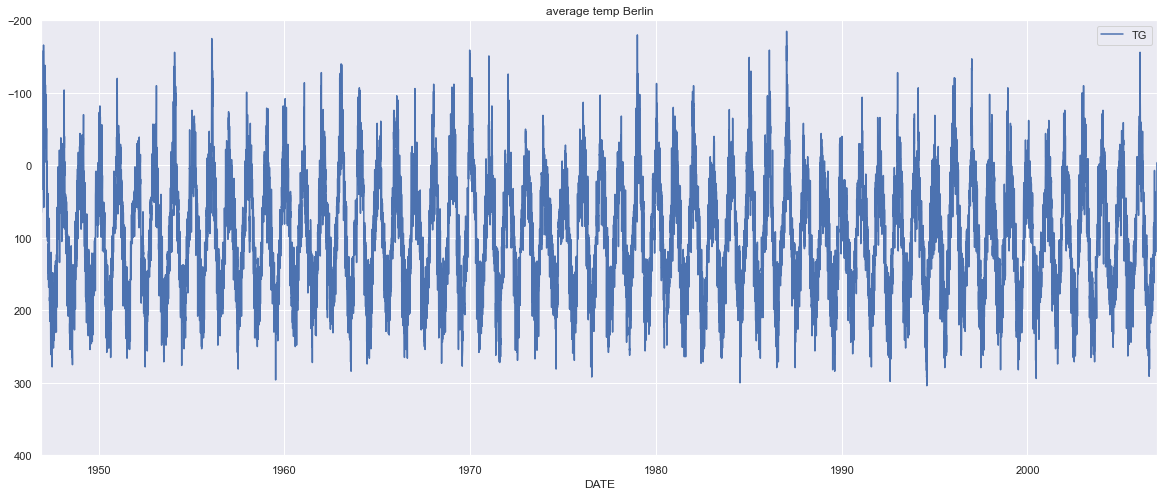

In [10]:
# plot data:
df_train.plot()
plt.title("average temp Berlin")
plt.ylim(400, -200)

Text(0.5, 1.0, 'average temp Berlin')

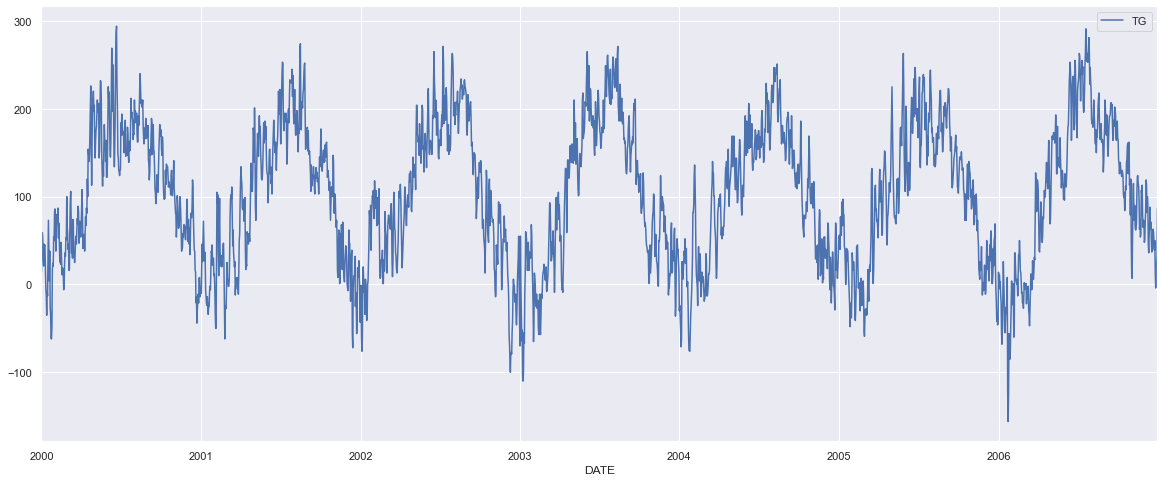

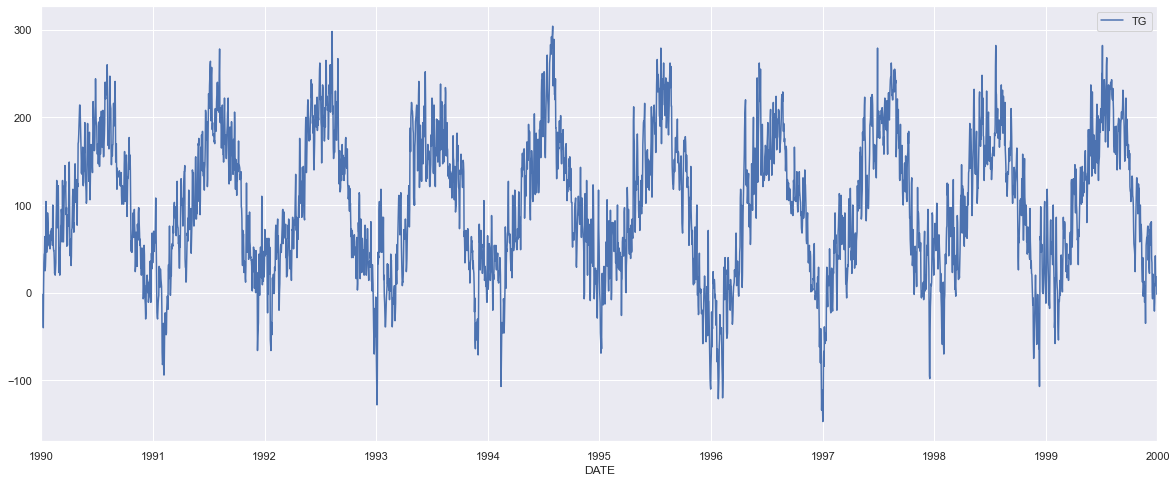

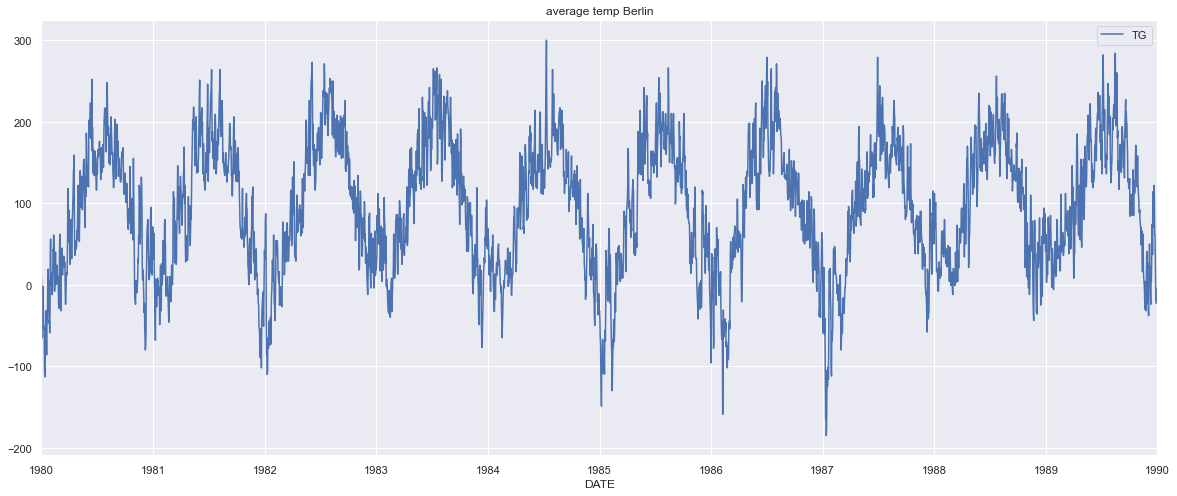

In [11]:
# plot last 7 years:
df_train.loc['2000-01-01': '2010-01-01'].plot()
# plot 2 decades before
df_train.loc['1990-01-01' : '2000-01-01'].plot()
df.loc['1980-01-01' : '1990-01-01'].plot()
plt.title("average temp Berlin")

<AxesSubplot:xlabel='DATE'>

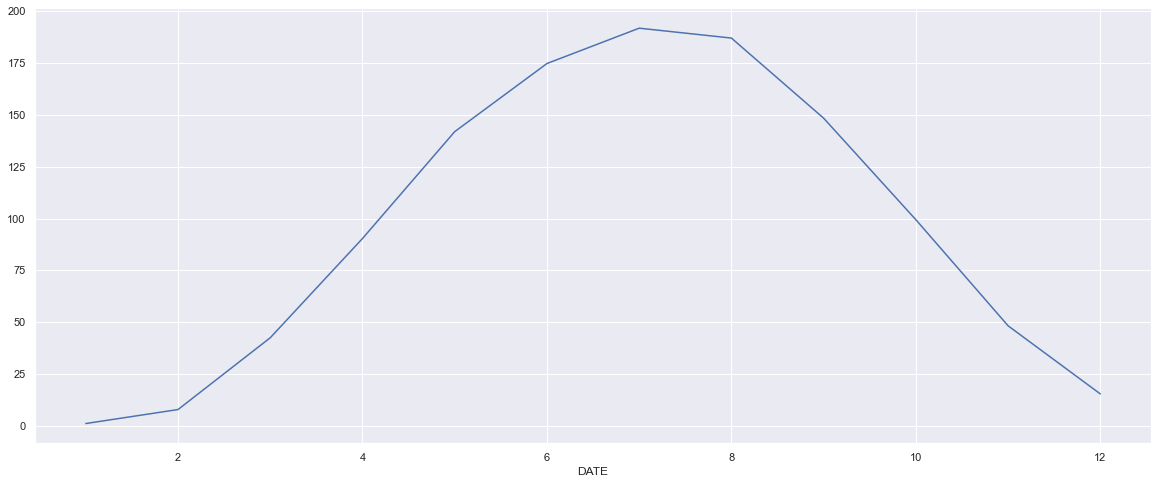

In [12]:
# plot monthly seasonality
df_train.groupby(df_train.index.month)['TG'].mean().plot()

<ipython-input-13-ff6992d8e83d>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_train.groupby(df_train.index.week)['TG'].mean().plot()


<AxesSubplot:xlabel='DATE'>

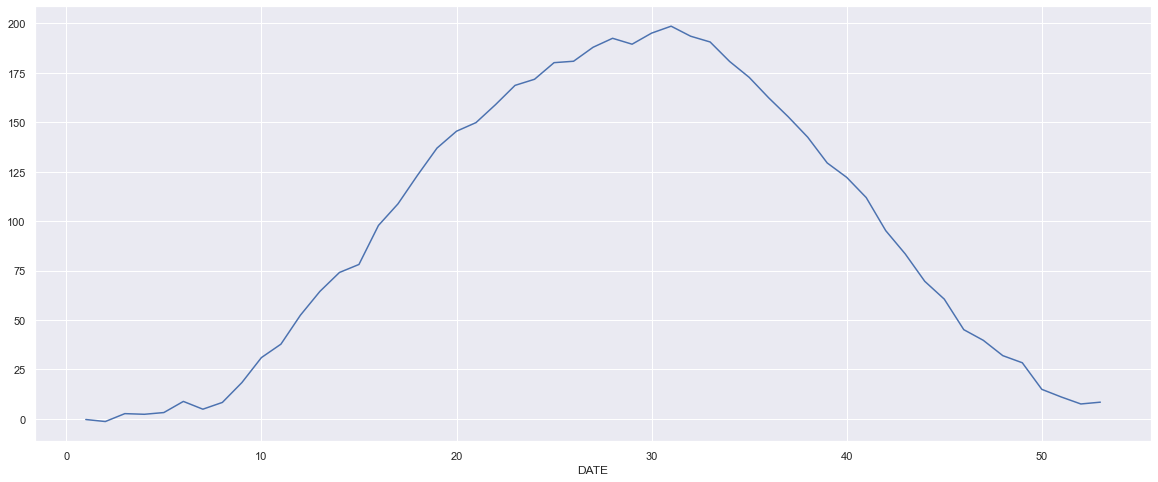

In [13]:
# plot monthly seasonality
df_train.groupby(df_train.index.week)['TG'].mean().plot()

<AxesSubplot:xlabel='DATE'>

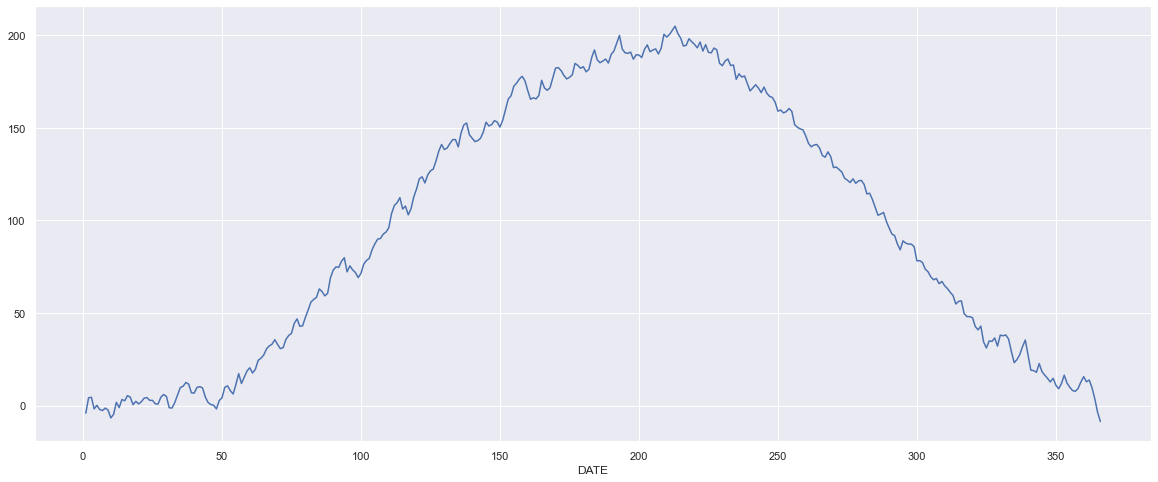

In [14]:
# plot daily seasonality:
df_train.groupby(df_train.index.dayofyear)['TG'].mean().plot()

<AxesSubplot:xlabel='DATE'>

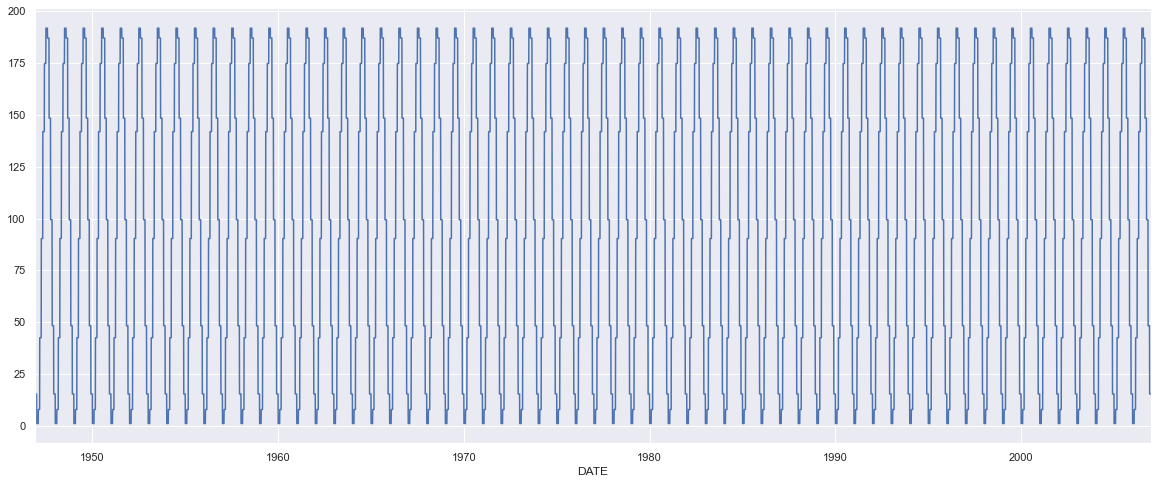

In [15]:
# 'remove' monthly seasonality:
df_train.groupby(df_train.index.month)['TG'].transform('mean').plot()

#### extract timesteps: 

In [16]:
# extract timesteps:
def get_timesteps(dataframe):
    
    dataframe['timestep'] = range(len(dataframe))
    
    return dataframe

In [17]:
df_train = get_timesteps(df_train)

#### plot trend

In [18]:
# Linear Regression model for plotting trend:
m_trend = LinearRegression()

In [19]:
# fit model to model trend on timesteps as X and temperature('TG') as y: 
Xtrend = df_train[['timestep']] # matrix
ytrend = df_train['TG'] # vector
m_trend.fit(Xtrend, ytrend)

LinearRegression()

In [20]:
#coefficient of LR:
m_trend.coef_ 

array([0.00046149])

In [21]:
# predict trend 
df_train['trend'] = m_trend.predict(Xtrend)

<AxesSubplot:xlabel='DATE'>

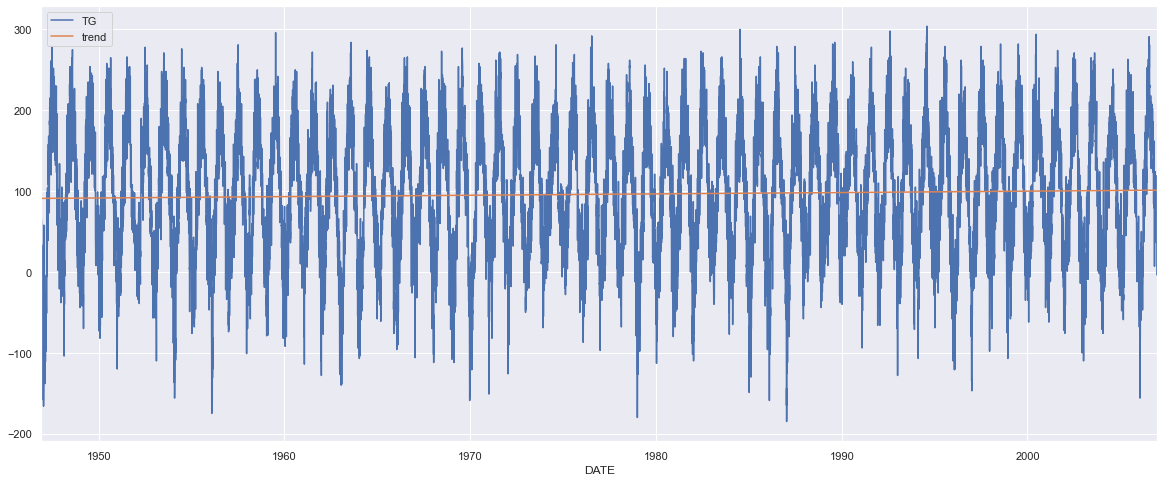

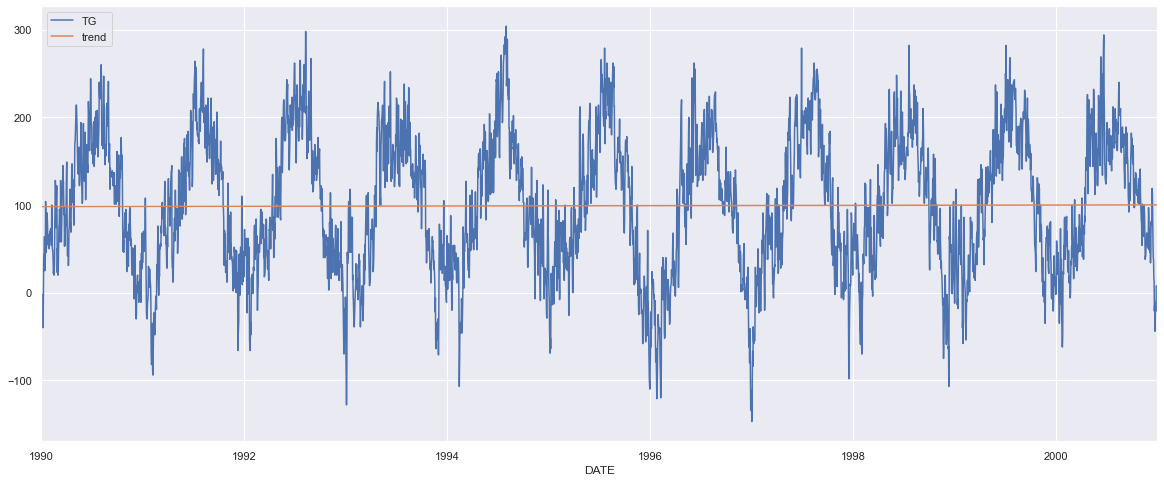

In [22]:
# plot trend: 
df_train[['TG', 'trend']].plot()
# trend for a decade:
df_train['1990' : '2000'][['TG', 'trend']].plot()

<AxesSubplot:xlabel='DATE'>

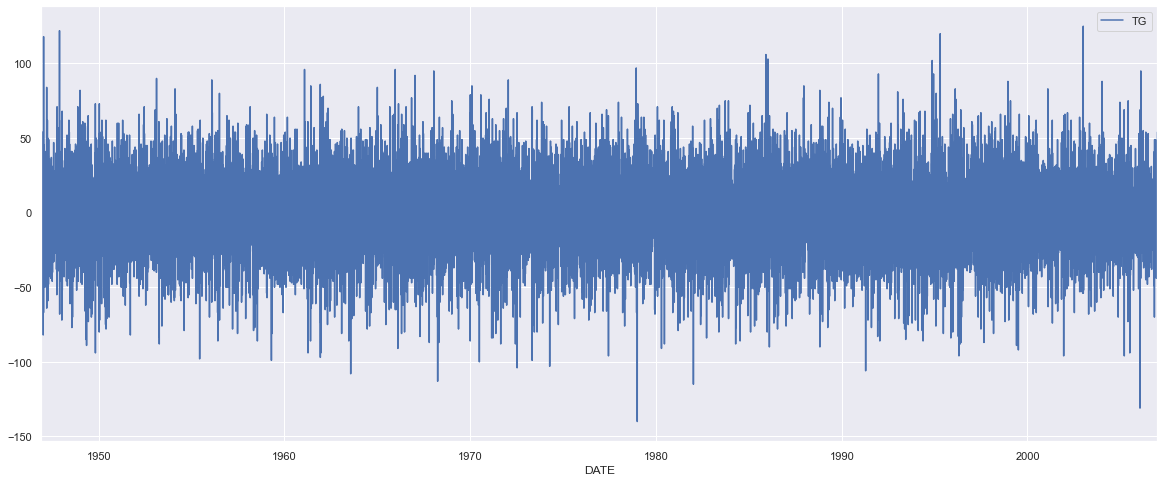

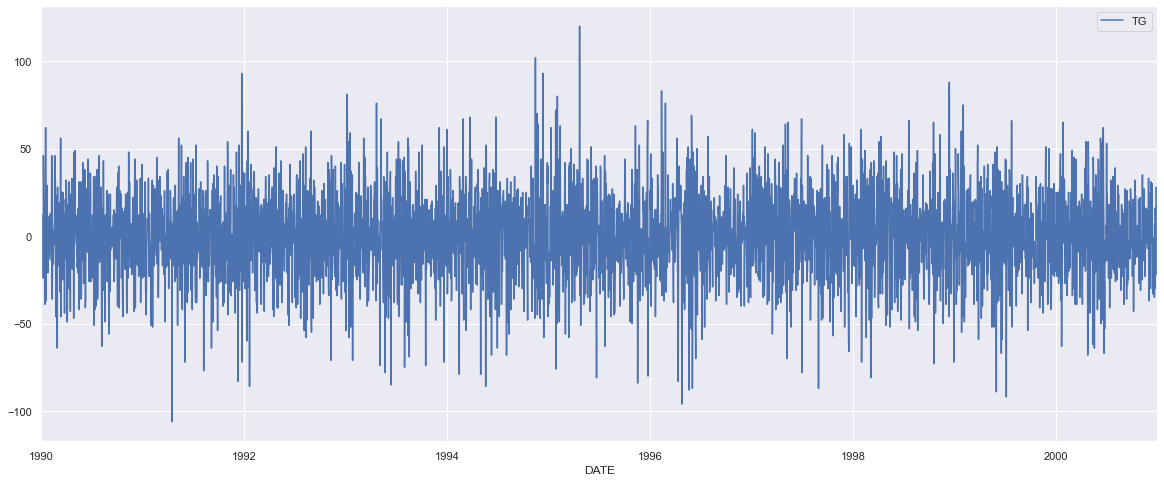

In [23]:
# plot original data without trend: 
df_train[['TG']].diff().plot() 
# for a decade: 
df_train['1990' : '2000'][['TG']].diff().plot() 

#### model monthly seasonality:

In [24]:
# create column month from datetimeseries: 
df_train['month'] = df_train.index.month

In [25]:
# datetimeseries attribute to get dummies for: 
dts_attrib = 'month'
dataframe = df_train  

In [26]:
def get_dummies(dataframe, dts_attrib:str): #, dts_indexing:str): 
    
    
    # dummy-encode timeseries attribute: 
    seasonal_dummies = pd.get_dummies(dataframe[dts_attrib], prefix='{}_'.format(dts_attrib), drop_first=True).set_index(dataframe.index)
    
    # merge df with dummies: 
    dataframe = dataframe.join(seasonal_dummies)
   # dataframe.drop(dts_attrib)
    
    return dataframe

In [27]:
# get dummies to dataframe:
df_train_months = get_dummies(dataframe, dts_attrib)

In [28]:
df_train_months.head()

,TG,timestep,trend,month,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
DATE,,,,,,,,,,,,,,,
1946-12-01,65,0,90.993228,12,0,0,0,0,0,0,0,0,0,0,1
1946-12-02,62,1,90.993690,12,0,0,0,0,0,0,0,0,0,0,1
1946-12-03,36,2,90.994151,12,0,0,0,0,0,0,0,0,0,0,1
1946-12-04,19,3,90.994613,12,0,0,0,0,0,0,0,0,0,0,1
1946-12-05,26,4,90.995074,12,0,0,0,0,0,0,0,0,0,0,1


In [29]:
# set X and y for model predicting on trend and seasonality'
X_ts = df_train_months.drop(['TG', 'month', 'trend'], axis=1)  
y_ts = df_train_months['TG']

# model for trend and seasonality: 
model_ts = LinearRegression()

# dataframe:
dataframe = df_train_months

In [30]:
X_ts

,timestep,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
DATE,,,,,,,,,,,,
1946-12-01,0,0,0,0,0,0,0,0,0,0,0,1
1946-12-02,1,0,0,0,0,0,0,0,0,0,0,1
1946-12-03,2,0,0,0,0,0,0,0,0,0,0,1
1946-12-04,3,0,0,0,0,0,0,0,0,0,0,1
1946-12-05,4,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-27,21941,0,0,0,0,0,0,0,0,0,0,1
2006-12-28,21942,0,0,0,0,0,0,0,0,0,0,1
2006-12-29,21943,0,0,0,0,0,0,0,0,0,0,1


In [31]:
# predict on trend_and_seasonality:
def get_t_and_s(model_ts, X_ts, y_ts, dataframe):
    
    # fit model on X and y
    model_ts.fit(X_ts,y_ts)
    # add column trend_and_seasonality to dataframe:
    dataframe['trend_and_seasonality'] = model_ts.predict(X_ts)
    
    return dataframe

In [32]:
df_train_months = get_t_and_s(model_ts, X_ts, y_ts, dataframe)

In [33]:
df_train_months.head()

,TG,timestep,trend,month,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,trend_and_seasonality
DATE,,,,,,,,,,,,,,,,
1946-12-01,65,0,90.993228,12,0,0,0,0,0,0,0,0,0,0,1,11.154113
1946-12-02,62,1,90.993690,12,0,0,0,0,0,0,0,0,0,0,1,11.154501
1946-12-03,36,2,90.994151,12,0,0,0,0,0,0,0,0,0,0,1,11.154890
1946-12-04,19,3,90.994613,12,0,0,0,0,0,0,0,0,0,0,1,11.155279
1946-12-05,26,4,90.995074,12,0,0,0,0,0,0,0,0,0,0,1,11.155668


<AxesSubplot:xlabel='DATE'>

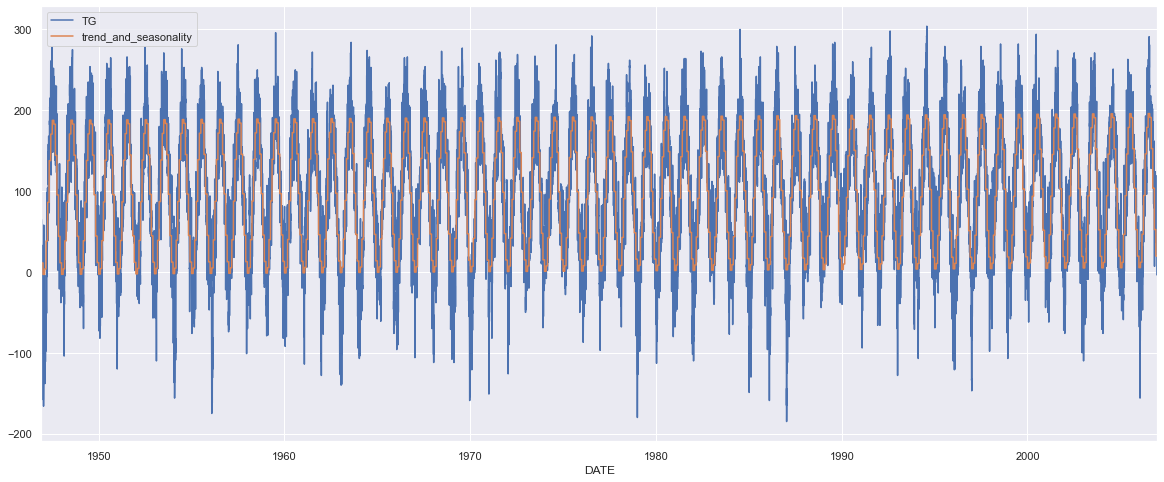

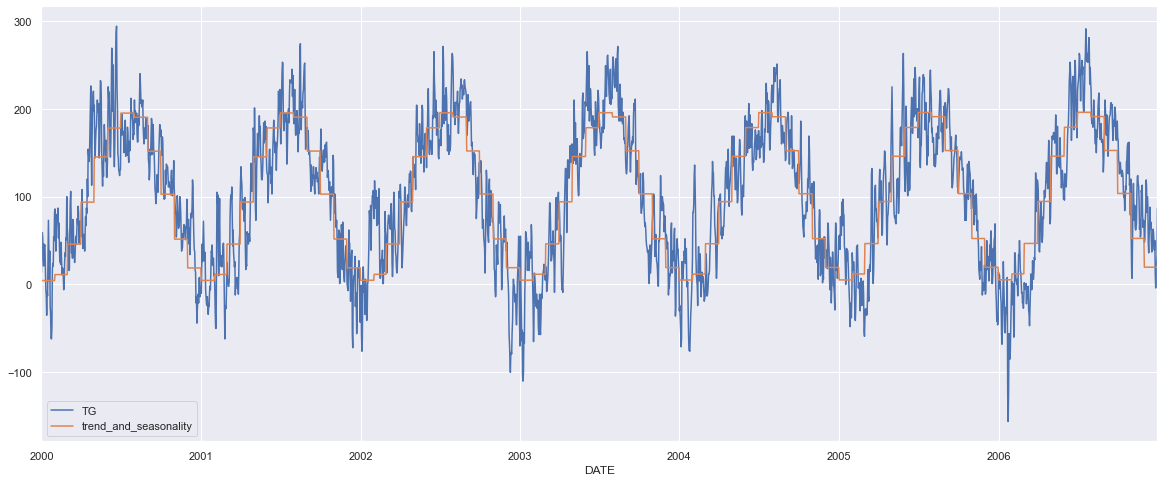

In [34]:
# plotting trend and seasonality against original data:
df_train_months[['TG', 'trend_and_seasonality']].plot()
df_train_months['2000' : '2010'][['TG', 'trend_and_seasonality']].plot() 

#### calculate remainder: 

In [35]:
# calculate remainder and insert to new column: 
df_train_months['remainder'] = df_train_months['TG'] - df_train_months['trend_and_seasonality'] 
# -- divide?! 

<AxesSubplot:title={'center':'Remainder after modellin trend and seasonality'}, xlabel='DATE'>

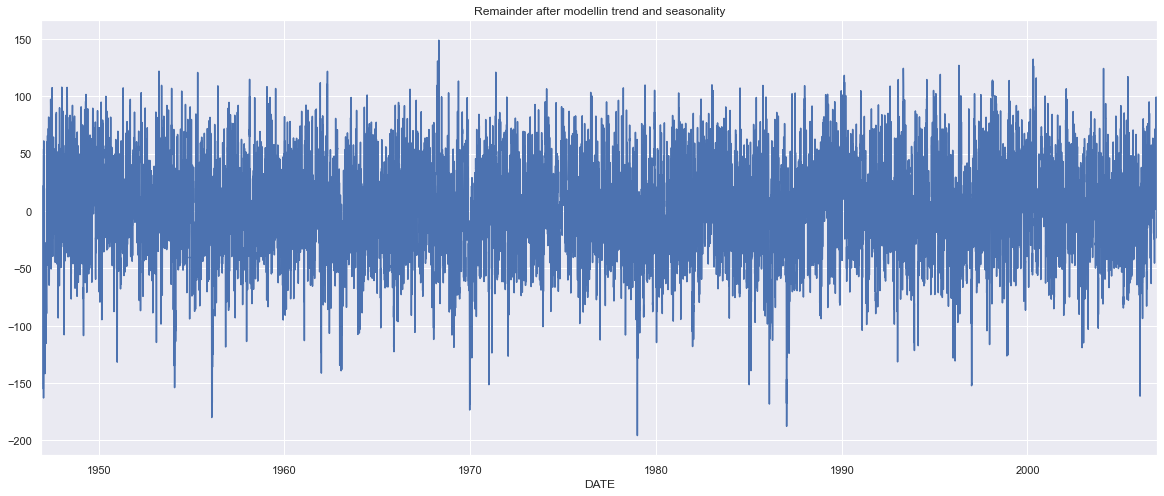

In [36]:
# plot remainder
df_train_months['remainder'].plot(title='Remainder after modellin trend and seasonality')

In [37]:
# use statsmodel for modeling and plotting trend, seasonality and residuals: 
sd = seasonal_decompose(df_train_months['TG'], period=365//4)

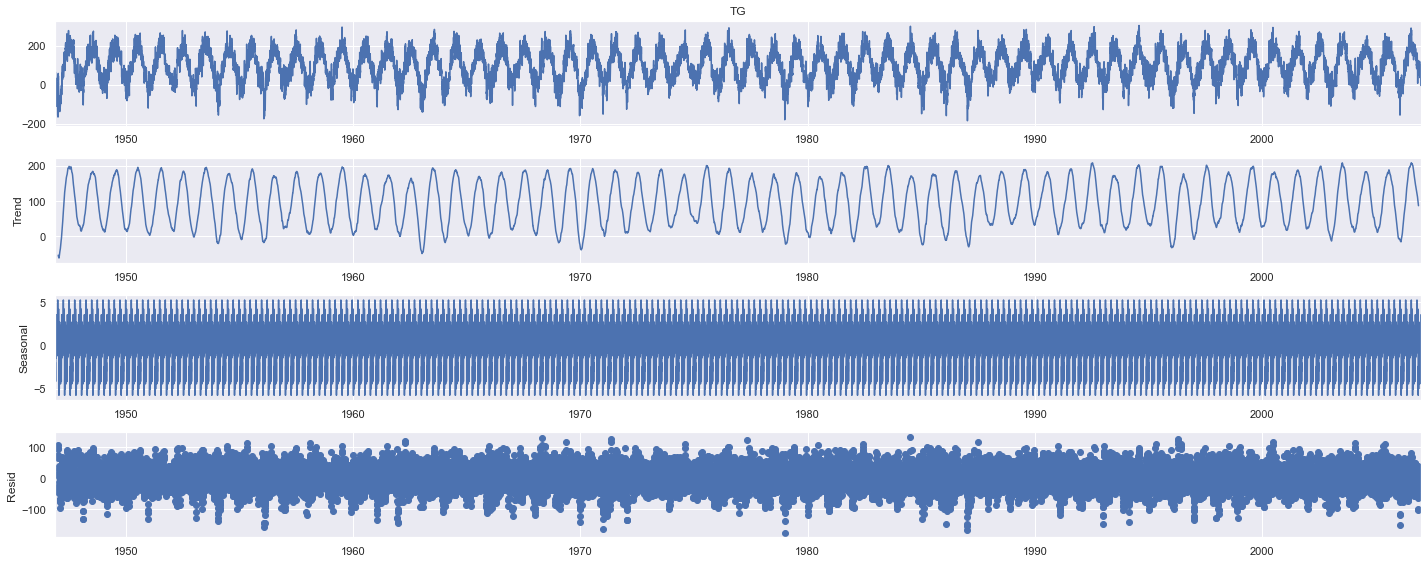

In [38]:
sd.plot();

#### check for best number of lags: 

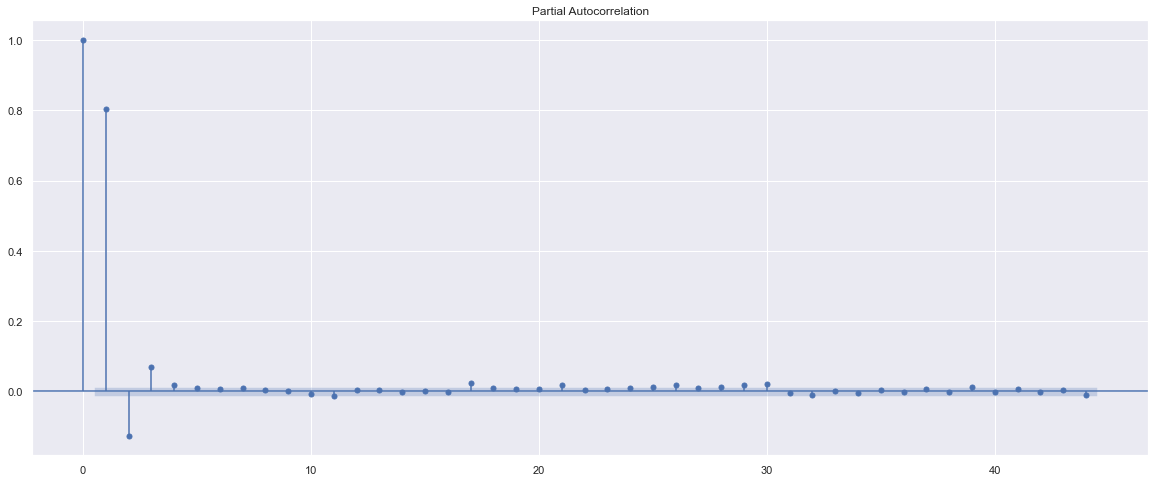

In [39]:
# check for number of lags with partial autocorrelation function:
plot_pacf(df_train_months['remainder']);

In [40]:
# check for best num of lags of remainder with statsmodel. Not able to remove frequency warning for now...: 
# ar_select_order: 
selected_order = ar_select_order(df_train_months['remainder'], maxlag=12, old_names=True, seasonal=True) #frequency?

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [41]:
# How many lags:
selected_order.ar_lags

array([1, 2, 3])

In [42]:
selected_order.bic 

{(1, 2, 3): 6.309226244191046,
 (1, 2, 3, 4): 6.309349472962457,
 (1, 2, 3, 4, 5): 6.309718972065088,
 (1, 2, 3, 4, 5, 6): 6.310130146114865,
 (1, 2, 3, 4, 5, 6, 7): 6.310520687179609,
 (1, 2, 3, 4, 5, 6, 7, 8): 6.310954554152578,
 (1, 2, 3, 4, 5, 6, 7, 8, 9): 6.311410136593785,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 6.311827707386884,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11): 6.312071351637908,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12): 6.312517845013792,
 (1, 2): 6.31344357852675,
 (1,): 6.329046999044109,
 0: 7.3682315537791565}

#### add 3 lags: 

In [43]:
dataframe = df_train_months

# create 3 lags in df_train_months that are lags of TG, not of remainder:
def get_three_lags(dataframe):
    ''' creates lags 1,2 and 3 and adds them as columns to dataframe. Returns dataframe.'''
    
    dataframe['lag1'] = dataframe['TG'].shift(1)
    dataframe['lag2'] = dataframe['TG'].shift(2)
    dataframe['lag3'] = dataframe['TG'].shift(3)
    
    return dataframe

In [44]:
# create 3 lags for training data:
df_train_months = get_three_lags(dataframe)

In [45]:
df_train_months.head()

,TG,timestep,trend,month,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,trend_and_seasonality,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,
1946-12-01,65,0,90.993228,12,0,0,0,0,0,0,0,0,0,0,1,11.154113,53.845887,NaN,NaN,NaN
1946-12-02,62,1,90.993690,12,0,0,0,0,0,0,0,0,0,0,1,11.154501,50.845499,65.0,NaN,NaN
1946-12-03,36,2,90.994151,12,0,0,0,0,0,0,0,0,0,0,1,11.154890,24.845110,62.0,65.0,NaN
1946-12-04,19,3,90.994613,12,0,0,0,0,0,0,0,0,0,0,1,11.155279,7.844721,36.0,62.0,65.0
1946-12-05,26,4,90.995074,12,0,0,0,0,0,0,0,0,0,0,1,11.155668,14.844332,19.0,36.0,62.0


In [46]:
# drop Nan's:
df_train_months.dropna(inplace=True)

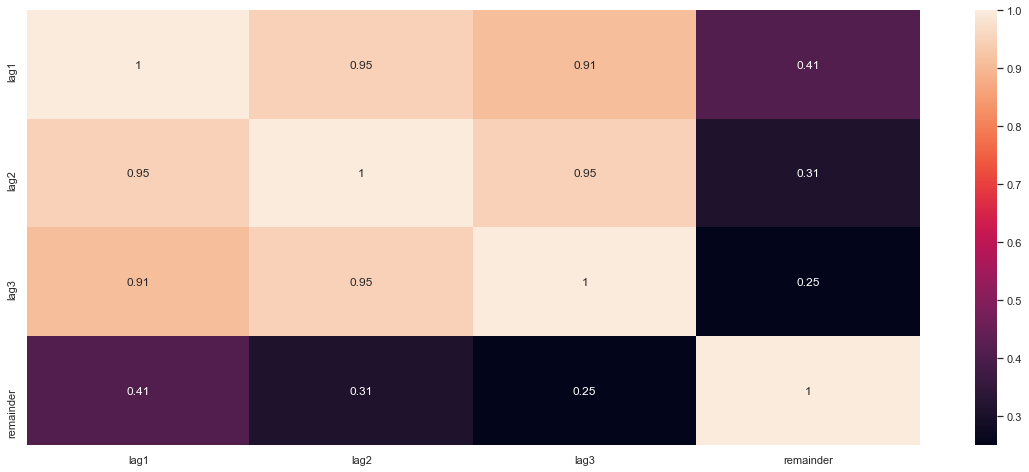

In [47]:
# inspect correlations of lags and remainder: 
sns.heatmap(round(df_train_months[['lag1', 'lag2', 'lag3', 'remainder']].corr(), 2), annot=True)
plt.show()

### Linear Regression:

#### making predictions with Linear Regression model after having eliminated trend and seasonality before: 

In [48]:
# assign X and y for model fit and prediction: 
X_full = df_train_months.drop(['TG', 'trend', 'trend_and_seasonality', 'remainder', 'month'], axis=1) #'trend', 
y_full_true = df_train_months['TG']

In [49]:
X_full

,timestep,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,
1946-12-04,3,0,0,0,0,0,0,0,0,0,0,1,36.0,62.0,65.0
1946-12-05,4,0,0,0,0,0,0,0,0,0,0,1,19.0,36.0,62.0
1946-12-06,5,0,0,0,0,0,0,0,0,0,0,1,26.0,19.0,36.0
1946-12-07,6,0,0,0,0,0,0,0,0,0,0,1,6.0,26.0,19.0
1946-12-08,7,0,0,0,0,0,0,0,0,0,0,1,6.0,6.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-27,21941,0,0,0,0,0,0,0,0,0,0,1,13.0,50.0,39.0
2006-12-28,21942,0,0,0,0,0,0,0,0,0,0,1,-4.0,13.0,50.0
2006-12-29,21943,0,0,0,0,0,0,0,0,0,0,1,-1.0,-4.0,13.0


In [50]:
# model for predictions on 'full' data:
m_full = LinearRegression()
# fit model on X_full and y_full_true: 
m_full.fit(X_full, y_full_true) 

LinearRegression()

In [51]:
# predict on X_full and add predictions as new column to dataframe:
dataframe = df_train_months

def get_pred_full(X_full, dataframe):
    ''' get predictions on full data (trend and seasonlity extracted) and added to new column in dataframe.
        Return dataframe and y_full_pred'''
    
    y_full_pred = m_full.predict(X_full)
    dataframe['predictions_full_model'] = m_full.predict(X_full)
    
    return y_full_pred, dataframe

In [52]:
y_full_pred, df_train_months = get_pred_full(X_full, dataframe)


#### Evaluation of model predictions on training data: 

In [53]:
dataframe = df_train_months

def evaluate_model(dataframe, X_full, y_full_true, y_full_pred):
    
    #plot predictions, temp  and trend&seasonality
    dataframe[['TG', 'trend_and_seasonality', 'predictions_full_model']].plot() 
    dataframe['2000' : '2010'][['TG', 'trend_and_seasonality', 'predictions_full_model']].plot()

    #cross-validation: 
    # Create a TimeSeriesSplit object
    ts_split = TimeSeriesSplit(n_splits=5)
    # Create the time series split
    time_series_split = ts_split.split(X_full, y_full_true)
    # Do the cross validation
    result = cross_val_score(estimator=m_full, X=X_full, y=y_full_true, cv=time_series_split)
    # print cross-validation result: 
    print('The mean of the crossvalidation result (r squared) is: ' + str(result.mean()))
    # print r squared:
    print('The calculated r squared score of the model is: ' + str(r2_score(y_full_true, y_full_pred)))
    # print MSE:
    print('The calculated MSE of the model is: ' + str(mean_squared_error(y_full_true, y_full_pred)))
    

The mean of the crossvalidation result (r squared) is: 0.9164226100010124
The calculated r squared score of the model is: 0.9184626150074426
The calculated MSE of the model is: 516.1827805237835


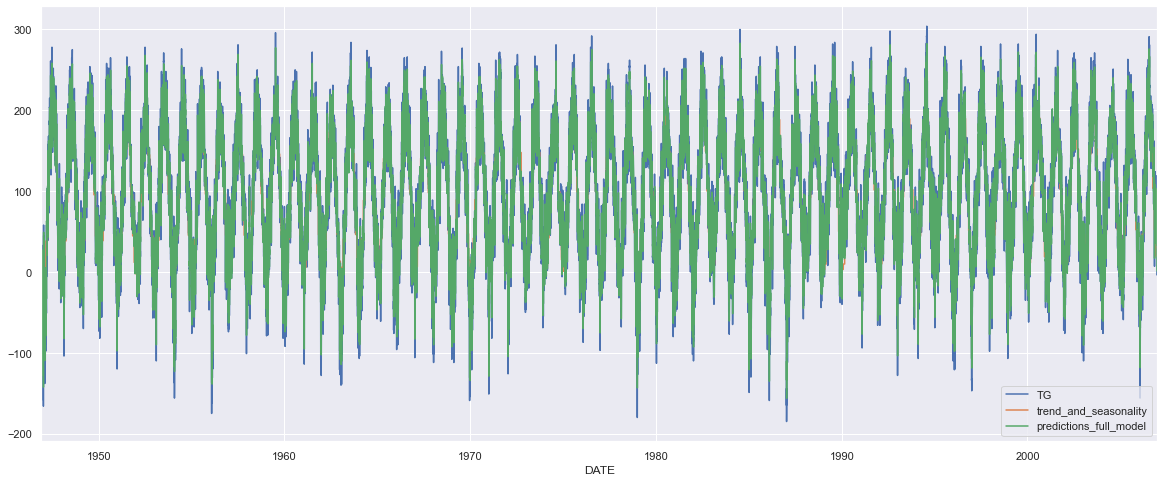

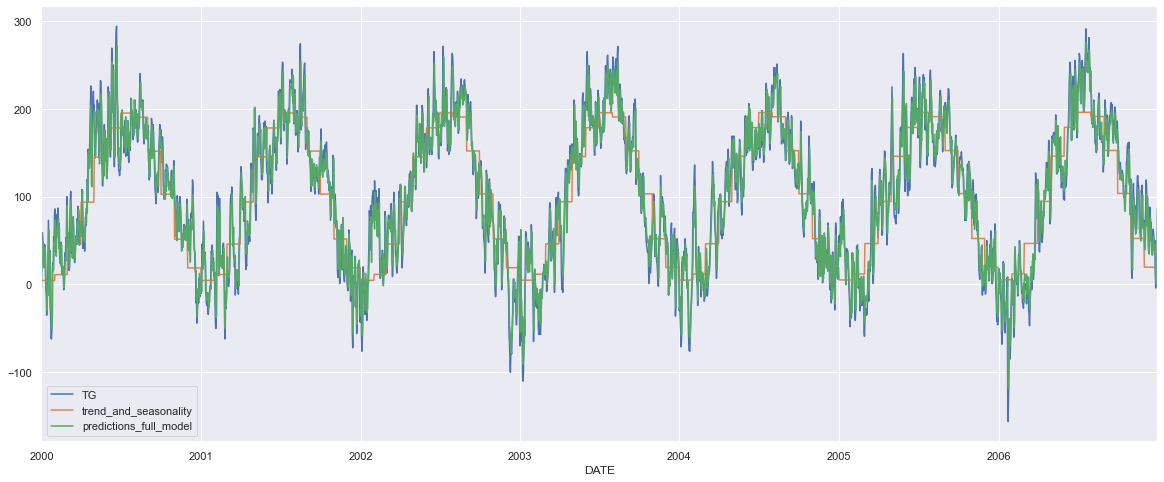

In [54]:
# evaluation: 
evaluate_model(dataframe, X_full, y_full_true, y_full_pred)

#### predict on test data with same LinReg model:

In [55]:
# Last timestep of the training data:
last_train_timestep = df_train_months['timestep'][-1]

In [56]:
# create timesteps for the model/test data: 
df_test['timestep'] = list(range(last_train_timestep + 1, last_train_timestep + 1 + len(df_test)))


In [57]:
# create column month from datetimeseries: 
df_test['month'] = df_test.index.month

In [58]:
# get seasonal dummies: 
df_test = get_dummies(dataframe=df_test, dts_attrib='month')

In [59]:
# Assign X_test, y_test_true: 
X_test = df_test.drop(columns=['TG', 'month'], axis=1)
y_test_true = df_test['TG']

In [60]:
X_test

,timestep,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
DATE,,,,,,,,,,,,
2007-01-01,21946,0,0,0,0,0,0,0,0,0,0,0
2007-01-02,21947,0,0,0,0,0,0,0,0,0,0,0
2007-01-03,21948,0,0,0,0,0,0,0,0,0,0,0
2007-01-04,21949,0,0,0,0,0,0,0,0,0,0,0
2007-01-05,21950,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,27055,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,27056,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,27057,0,0,0,0,0,0,0,0,0,0,1


In [61]:
# Predict trend and seasonality and add to new column:
df_test['trend_and_seasonality'] = model_ts.predict(X_test)

In [62]:
df_test

,TG,timestep,month,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,trend_and_seasonality
DATE,,,,,,,,,,,,,,,
2007-01-01,83,21946,1,0,0,0,0,0,0,0,0,0,0,0,5.480383
2007-01-02,48,21947,1,0,0,0,0,0,0,0,0,0,0,0,5.480772
2007-01-03,54,21948,1,0,0,0,0,0,0,0,0,0,0,0,5.481161
2007-01-04,69,21949,1,0,0,0,0,0,0,0,0,0,0,0,5.481550
2007-01-05,74,21950,1,0,0,0,0,0,0,0,0,0,0,0,5.481939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,16,27055,12,0,0,0,0,0,0,0,0,0,0,1,21.674756
2020-12-28,28,27056,12,0,0,0,0,0,0,0,0,0,0,1,21.675145
2020-12-29,23,27057,12,0,0,0,0,0,0,0,0,0,0,1,21.675533


<AxesSubplot:xlabel='DATE'>

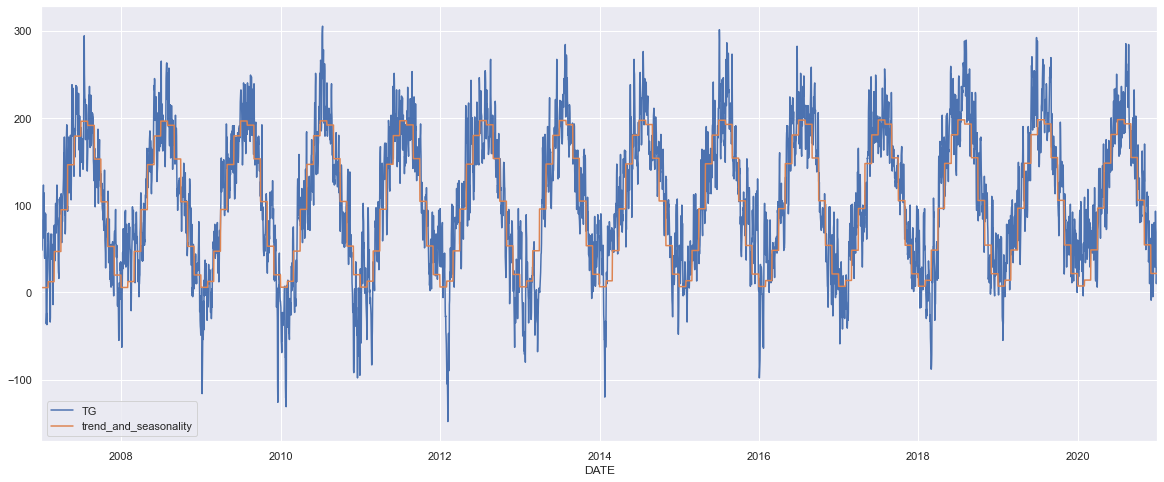

In [63]:
# plot seasonality and original data: 
df_test[['TG', 'trend_and_seasonality']].plot()

In [64]:
# Calculate the remainder for the test set
df_test['remainder'] = df_test['TG'] - df_test['trend_and_seasonality']

In [65]:
# Create the lagged variables
df_test_months = get_three_lags(df_test)

In [66]:
df_test_months.head()

,TG,timestep,month,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,trend_and_seasonality,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,
2007-01-01,83,21946,1,0,0,0,0,0,0,0,0,0,0,0,5.480383,77.519617,NaN,NaN,NaN
2007-01-02,48,21947,1,0,0,0,0,0,0,0,0,0,0,0,5.480772,42.519228,83.0,NaN,NaN
2007-01-03,54,21948,1,0,0,0,0,0,0,0,0,0,0,0,5.481161,48.518839,48.0,83.0,NaN
2007-01-04,69,21949,1,0,0,0,0,0,0,0,0,0,0,0,5.481550,63.518450,54.0,48.0,83.0
2007-01-05,74,21950,1,0,0,0,0,0,0,0,0,0,0,0,5.481939,68.518061,69.0,54.0,48.0


In [67]:
# function for this one?
# fill Nan's
df_test_months.loc['2007-01-01', 'lag1'] = df_train_months.loc['2006-12-31', 'TG']
df_test_months.loc['2007-01-02', 'lag2'] = df_train_months.loc['2006-12-31', 'TG']
df_test_months.loc['2007-01-03', 'lag3'] = df_train_months.loc['2006-12-31', 'TG']

df_test_months.loc['2007-01-01', 'lag2'] = df_train_months.loc['2006-12-30', 'TG']
df_test_months.loc['2007-01-02', 'lag3'] = df_train_months.loc['2006-12-30', 'TG']

df_test_months.loc['2007-01-01', 'lag3'] = df_train_months.loc['2006-12-29', 'TG']

In [68]:
# Assign X_full_test:
X_full_t = df_test_months.drop(columns=['TG', 'trend_and_seasonality', 'remainder', 'month'])

In [69]:
#X_full_t

In [70]:
# Create the predictions and add to new column: 
y_test_pred = m_full.predict(X_full_t)
df_test['predictions_full_model'] = m_full.predict(X_full_t)

#### test evaluation: 

The mean of the crossvalidation result (r squared) is: 0.9233604396778443
The calculated r squared score of the model is: 0.9246930126769461
The calculated MSE of the model is: 450.97211823661695


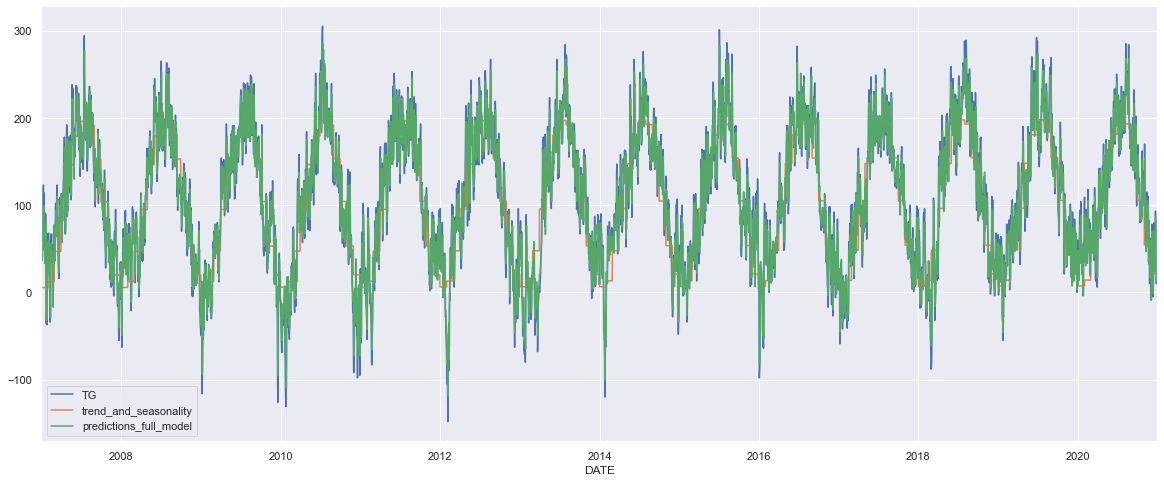

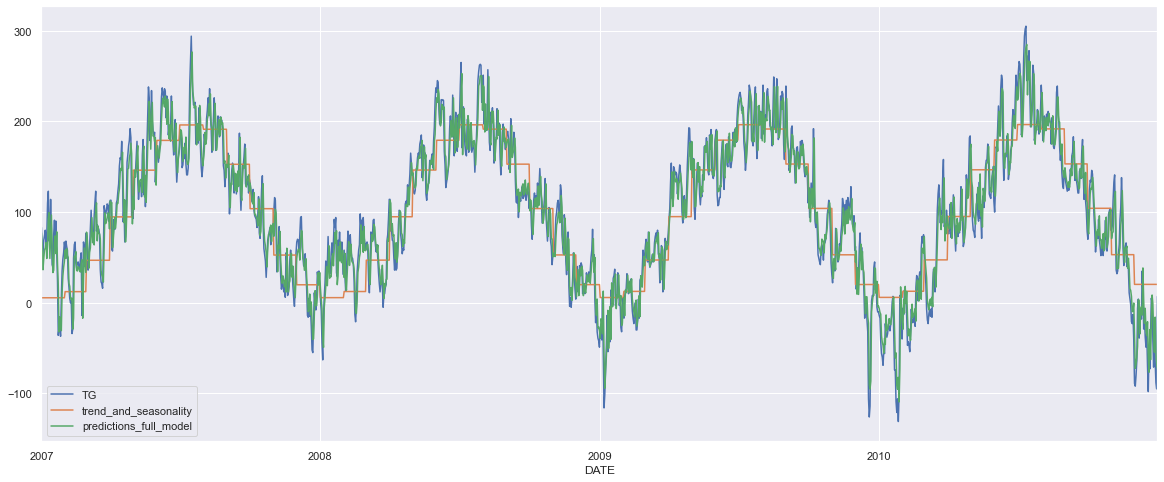

In [71]:
# evaluation of predictions on test data: 
dataframe = df_test_months

evaluate_model(dataframe, X_full_t, y_test_true, y_test_pred)

### predict the future tadadaaa

In [72]:
# Combine train and test data 
df_combined = df_train_months.append(df_test)
df_combined.tail()

,TG,timestep,trend,month,month__2,month__3,month__4,month__5,month__6,month__7,...,month__9,month__10,month__11,month__12,trend_and_seasonality,remainder,lag1,lag2,lag3,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,,
2020-12-27,16,27055,NaN,12,0,0,0,0,0,0,...,0,0,0,1,21.674756,-5.674756,10.0,27.0,69.0,13.080039
2020-12-28,28,27056,NaN,12,0,0,0,0,0,0,...,0,0,0,1,21.675145,6.324855,16.0,10.0,27.0,18.479048
2020-12-29,23,27057,NaN,12,0,0,0,0,0,0,...,0,0,0,1,21.675533,1.324467,28.0,16.0,10.0,26.956240
2020-12-30,25,27058,NaN,12,0,0,0,0,0,0,...,0,0,0,1,21.675922,3.324078,23.0,28.0,16.0,20.421354
2020-12-31,26,27059,NaN,12,0,0,0,0,0,0,...,0,0,0,1,21.676311,4.323689,25.0,23.0,28.0,24.302416


In [73]:
# Assign X and y for combined dataset:
X_combined = df_combined.drop(columns=['TG', 'month', 'trend', 'trend_and_seasonality', 'remainder', 'predictions_full_model'])
y_combined = df_combined['TG']

In [74]:
# Re-train model on the whole dataset
m_combined = LinearRegression()
m_combined_fit = m_combined.fit(X_combined, y_combined)

In [75]:
# function for predicting the temp at certain day. Still needs improvement/forecasting of three days!!

def predict_temp_of(date_time_str:str):
    ''' hopefully predicts the temperature at date that is passes as an argument. Date shoul be entered in 
        format: yyyy-mm-dd. Last day of dataset is 2020-12-31 so far. So for now this is only relevant to predict
        2021-01-01...'''
    
    
    X_future = []
    timestep = df_combined['timestep'].max() + 1
    months = [0] * 11  
    
    date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')
    
    
    lag1 = df_combined.loc[(date_time_obj + datetime.timedelta(days=-1)), 'TG']
    lag2 = df_combined.loc[(date_time_obj + datetime.timedelta(days=-2)), 'TG']
    lag3 = df_combined.loc[(date_time_obj + datetime.timedelta(days=-3)), 'TG']

    X_future.append(timestep)
    X_future.extend(months)

    X_future.append(lag1)
    X_future.append(lag2)
    X_future.append(lag3)
    
    X_future_df = pd.DataFrame([X_future], columns = ['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12','lag1', 'lag2', 'lag3'])
    X_future_df.rename(index={0:pd.to_datetime(date_time_obj)},inplace=True)
    
    X_future_df['predicted_temp'] = str((m_combined_fit.predict(X_future_df))* 0.1) + ' °C'
    
    return X_future_df

In [76]:
#predict temp at first day after last date included in data: 
X_future_df = predict_temp_of('2021-01-01')

In [77]:
X_future_df

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,predicted_temp
2021-01-01,27060,0,0,0,0,0,0,0,0,0,0,0,26,25,23,[2.33798748] °C


### TRY ARIMA MODEL ( not complete) :

#### check if AR or ARIMA model is better:

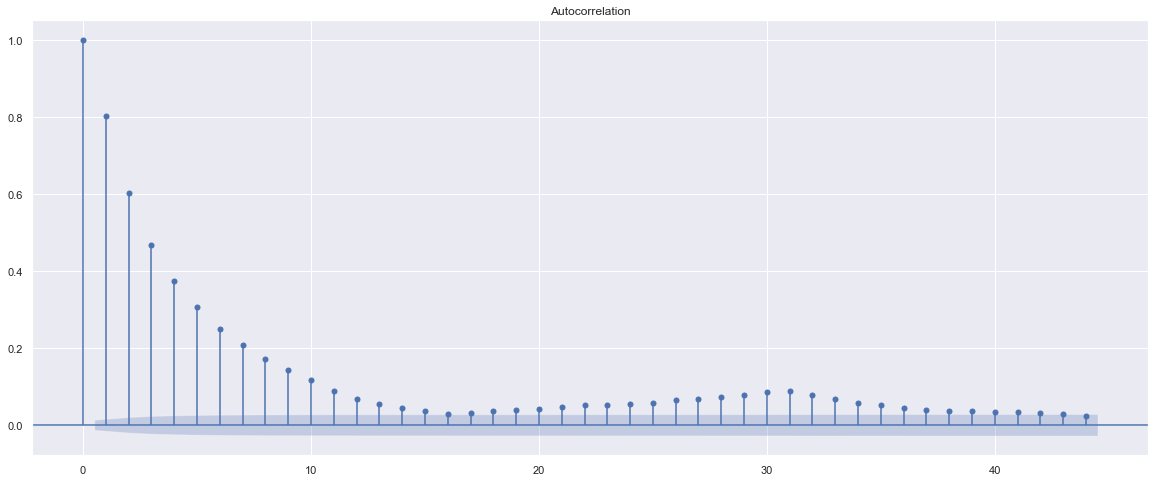

In [78]:
# plot autocorrelation function:
plot_acf(df_train_months['remainder']);

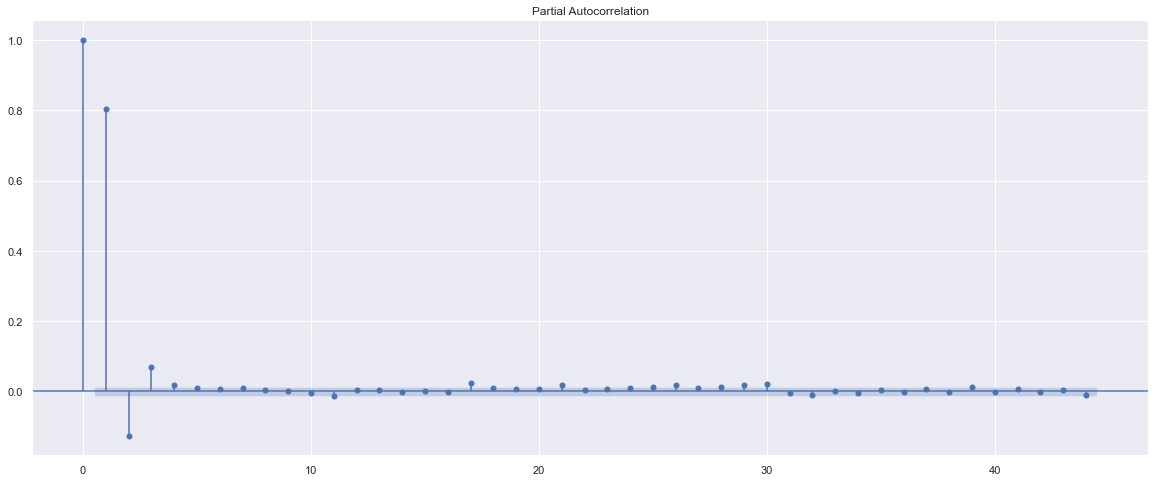

In [79]:
# plot partial autocorrelation function
plot_pacf(df_train_months['remainder']); 

In [80]:
X_arima = df_train_months['remainder']

In [81]:
#df_train_months.index

In [82]:
# Fit an ARIMA model - also frequency problem...
arima_model = ARIMA(X_arima, order=(1,1,1)).fit() # frequency information??

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [83]:
# Look at the summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              remainder   No. Observations:                21943
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -100536.910
Date:                Fri, 26 Feb 2021   AIC                         201079.820
Time:                        16:01:57   BIC                         201103.809
Sample:                    12-04-1946   HQIC                        201087.633
                         - 12-31-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8036      0.004    216.249      0.000       0.796       0.811
ma.L1         -0.9997      0.000  -4706.342      0.000      -1.000      -0.999
sigma2       558.8026      4.685    119.272      0.000     549.620     567.985
===================================================================================
Ljung-Box (L1) (Q):                 226.56   Jarque-Bera (JB):               448.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.06
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

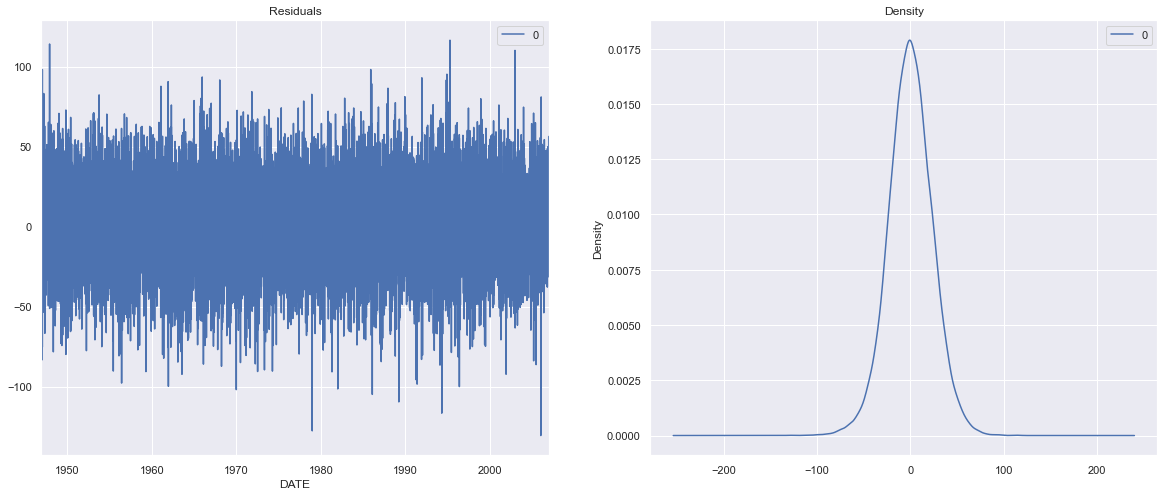

In [84]:
# Plot residual errors
residuals = pd.DataFrame(arima_model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

#### auto_ARIMA

In [85]:
#! pip install pmdarima

In [86]:
# fit ARIMA model: 
#stepwise_fit = pm.auto_arima(df_train_months['remainder'], start_p=1, start_q=1,
                             #max_p=3, max_q=3, m=12,
                             #start_P=0, seasonal=True,
                             #d=1, D=1, trace=True,
                             #error_action='ignore',  # don't want to know if an order does not work
                             #suppress_warnings=True,  # don't want convergence warnings
                             #stepwise=True)  # set to stepwise
# beware: takes a hundred years...

In [87]:
#stepwise_fit.summary()